# Predicting Used Cars Sale Price
Buying and selling a car are important decision as prices are usually high, even for used cars. For this reason, it's important for sellers to be able to estimate their car at a right price and avoid underestimation, as for buyers to avoid choosing a car that is selling above their expected value.

### Objective
The purpose of this project is to predict sale price of used cars based on different characteristics of a given car.

### Performance
To do so, a regression model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* **RMSE:** Root Squared of the Mean Squared Error. It is calculated by the sum of square of prediction error: $\sum(\hat{y}-y)^2/N$. Less robust to outliers, it gives a higher weight to large errors (as all errors are squared).
* **MAE:** Mean Absolute Error. It is the sum of the average absolute errors, this means that positive and negative errors cancel each other out. However, this also means that the effect of outliers is reduced with respect to RMSE. 
* **R2:** "*proportion of the variation in the dependent variable that is predictable from the independent variable.*" (source: Wikipedia)

===================================================================================================

# Feature Engineering Pipeline
===================================================================================================

# Import Libraries

In [1]:
# to handle datasets & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

# from sklearn
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# from feature_engine
from feature_engine.encoding import  RareLabelEncoder, CountFrequencyEncoder , OneHotEncoder
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from feature_engine.transformation import LogTransformer

# for interpretations
import warnings
import shap

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# for bringing external data
import pickle



# to display all the columns of the dataframe in the notebook & all float numbers rounded to 2digits
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Load & split data

In [2]:
raw_data = pd.read_csv('scraped_data_used_cars.csv')

In [3]:
# Removing duplicates
data = raw_data.drop_duplicates()

# Removing unnecesary feature
data = data.drop(['Model'], axis = 1) 

# Removing rows containing errors & extreme values
years_with_errors = data[(data.Years < 1800) | (data.Years > 2022)].index
data = data.drop(years_with_errors)

extreme_prices = data[(data['Prices'] < 500) | (data['Prices'] > 600000)].index
data = data.drop(extreme_prices)

seats_with_errors = data[data.Seats > 10]['Seats'].values
data.Seats = data.Seats.replace(to_replace = seats_with_errors, value = np.nan)

# Removing rows with missing prices
data = data.dropna(subset = ['Prices'])

# Checking result
print('Data without errors:', data.shape)
data.head(3)

Data without errors: (48575, 11)


,Prices,Years,Brand,Kms,Fuel,Emiss_CO2,Cons_litres_100km,Transmission,Doors,Power_CV,Seats
0,21250.00,2019.00,Renault,9500.00,Essence,136.00,6.00,Manuelle,4.00,9.00,5.00
2,22000.00,1974.00,Volkswagen,100000.00,Essence,165.00,6.80,Manuelle,2.00,9.00,4.00
4,1500.00,2006.00,Toyota,278000.00,Diesel,82.00,6.20,Manuelle,4.00,7.00,5.00


In [4]:
train_set, test_set = train_test_split(data, test_size = 0.1, random_state = 42) 
train_set.to_csv('train.csv')
test_set.to_csv('test.csv')

In [5]:
# Checking result
print('Train set without errors:', train_set.shape)

Train set without errors: (43717, 11)


In [6]:
# Checking result
print('Test set without errors:', test_set.shape)

Test set without errors: (4858, 11)


In [7]:
# Separing target from features
# predictive variables
X_train,  X_test = train_set.drop(['Prices'], axis=1), test_set.drop(['Prices'], axis=1) 

# target
y_train, y_test = train_set['Prices'], test_set['Prices'] 

# Checking results
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (43717, 10) (43717,)
Test set: (4858, 10) (4858,)


# Configuration

## Target

In [8]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Features

In [9]:
X_train.columns

Index(['Years', 'Brand', 'Kms', 'Fuel', 'Emiss_CO2', 'Cons_litres_100km',
       'Transmission', 'Doors', 'Power_CV', 'Seats'],
      dtype='object')

### Categorical variables

In [10]:
# Categorical variables
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['Brand', 'Fuel', 'Transmission']

In [11]:
# Variables with missing values
cat_vars_nan = [var for var in cat_vars if X_train[var].isnull().sum() > 0]
cat_vars_nan

['Brand', 'Fuel', 'Transmission']

In [12]:
# Type of imputation
cat_vars_with_nan_frequent = [var for var in cat_vars_nan if X_train[var].isnull().mean() < 0.1]
cat_vars_with_nan_frequent

['Brand', 'Fuel', 'Transmission']

### Numerical variables

In [13]:
# Numerical variables 
num_vars = [var for var in X_train.columns if var not in cat_vars]

In [14]:
# Variables with missing values
num_vars_nan = [var for var in num_vars if X_train[var].isnull().sum() > 0]
num_vars_nan

['Years',
 'Kms',
 'Emiss_CO2',
 'Cons_litres_100km',
 'Doors',
 'Power_CV',
 'Seats']

### Others

In [15]:
# Variables to log-transform
num_log_vars = ['Kms']

# Variables to encode by frequency
freq_encode = ['Brand']

# Variables with rare labels to regroup
rare_labels = ['Fuel', 'Transmission']

## Custom functions

In [16]:
def brand_country(X):
    # Load data
    df_car_origin = pd.read_csv('scraped_brands_per_country.csv')

    # Creating a dict with brand & country
    dict_cars_origin = {}

    for brand in set(X.Brand):
        brand_isin = df_car_origin[df_car_origin.isin([f'{brand.lower()}'])].stack()

        if len(brand_isin) > 0:
            country = brand_isin.index[0][1]

            # Filtering for "France" & "Germany"
            if (country == 'france') or (country == 'germany'):
                dict_cars_origin[f'{brand}'] = country
            else:
                dict_cars_origin[f'{brand}'] = 'other'
    
    s1 = set(X.Brand)
    s2 = set(dict_cars_origin.keys())

    for brand in s1.difference(s2):
        dict_cars_origin[brand] = 'other'
    
    # Mapping results
    X['Country_brand'] = X['Brand'].map(dict_cars_origin)
    return X

In [17]:
def luxury_brand(X):
    # Load data
    with open("luxury_cars_list", "rb") as fp:   
        luxury_cars_list = pickle.load(fp)        
    luxury_cars_list.append('tesla')
    # Creating a dict with brand & luxury brands
    dict_lux_cars = {}
    for car in X.Brand:
        if (car == 'Rolls-royce') or (car == 'Mercedes') or (car == 'Land-rover') or (car == 'Aston'):
            dict_lux_cars[car] = 1
        else:
            if car.lower() in luxury_cars_list:
                dict_lux_cars[car] = 1
            else:
                dict_lux_cars[car] = 0

    # Mapping results 
    X['Luxury_brand'] = X.Brand.map(dict_lux_cars)

    return X

# Feature Engineering Pipeline
All steps of the Feature Engineering process are combined in this pipeline, except for scaling which is added later to not lose the names of the features.

In [18]:
feature_engineering_pipeline = Pipeline([   
    # ==== HANDLE MISSING VALUES ====
     # impute "mean" for features with less than 10% of missing values
     ('frequent_imputation', CategoricalImputer(
                            imputation_method = 'frequent', variables = cat_vars_with_nan_frequent)),
    
     # add missing indicator & impute "mean" to numerical varaibles 
     ('missing_indicator', AddMissingIndicator(variables=num_vars_nan)),
    
     ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=num_vars_nan)),

    
    # ==== APPLY LOG TRANSFORMATION TO NUM VARIABLES ====
     # log transformation
     ('log', LogTransformer(variables=num_log_vars)),
  
    
    # ==== ADDING NEW FEATURES FROM BRAND ====
     # new features 
     ('add_brand_country', FunctionTransformer(brand_country)),
     ('add_luxury_brand', FunctionTransformer(luxury_brand)),
    
    
    # ==== ENCODING CATEGORICAL VARIABLES ====
     # Applying frequent encoder
     ('missing_brands', RareLabelEncoder(tol = 0.001, 
                                    variables = 'Brand' ,
                                    replace_with = 0)), 
     ('frequency_encoder', CountFrequencyEncoder(variables = freq_encode)),

   
    
     # Applying rare label encoder
     ('rare_label_encoder', RareLabelEncoder(tol = 0.05, 
                                n_categories = 2, 
                                variables = rare_labels ,
                                replace_with = 'Other')),
    
     # Applying one-hot encoder
     ('one_hot_encoder', OneHotEncoder()),
    
    
])    


## Fit Pipeline

In [19]:
feature_engineering_pipeline.fit(X_train)

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Brand', 'Fuel',
                                               'Transmission'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['Years', 'Kms', 'Emiss_CO2',
                                                'Cons_litres_100km', 'Doors',
                                                'Power_CV', 'Seats'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Years', 'Kms', 'Emi...
                 FunctionTransformer(func=<function luxury_brand at 0x0000017E104993A0>)),
                ('missing_brands',
                 RareLabelEncoder(replace_with=0, tol=0.001,
                                  variables='Brand')),
                ('frequency_encoder',
                 CountFrequencyEncoder(variables=['B

In [20]:
## Transform datasets & get feature names
X_train = feature_engineering_pipeline.transform(X_train)
feat_names = X_train.columns

X_test = feature_engineering_pipeline.transform(X_test)

In [21]:
# Check results
print(X_train.shape, X_test.shape)

(43717, 25) (4858, 25)


In [22]:
# Adding scaler
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Check results
print(X_train.shape, X_test.shape)

(43717, 25) (4858, 25)


## Unpickling best model

In [24]:
model = pickle.load(open('XGBRegressor.pkl', 'rb'))
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.06, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=350, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=1.0, reg_lambda=0.7, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# Getting predicted values
y_pred = model.predict(X_train)

# Transforming back to original scale
y_pred = np.exp(y_pred)
y_train = np.exp(y_train)

# Getting metrics
rmse = mean_squared_error(y_train, y_pred, squared=False)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

In [26]:
# determine rmse, mae, and r2
print('train mean price:', round(y_train.mean()))
print('train std price:', round(y_train.std()))

print('\ntrain rmse:', round(rmse))
print('train mae:',  round(mae))

print('\ntrain r2:', round(r2, 3))

train mean price: 26046
train std price: 25445

train rmse: 5774
train mae: 2444

train r2: 0.949


In [27]:
# Getting predicted values
y_pred = model.predict(X_test)

# Transforming back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

# Getting metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [28]:
# determine rmse, mae, and r2
print('test mean price:', round(y_test.mean()))
print('test std price:', round(y_test.std()))

print('\ntest rmse:', round(rmse))
print('test mae:',  round(mae))

print('\ntest r2:', round(r2, 3))

test mean price: 26155
test std price: 24773

test rmse: 8883
test mae: 3803

test r2: 0.871


### Visualizations

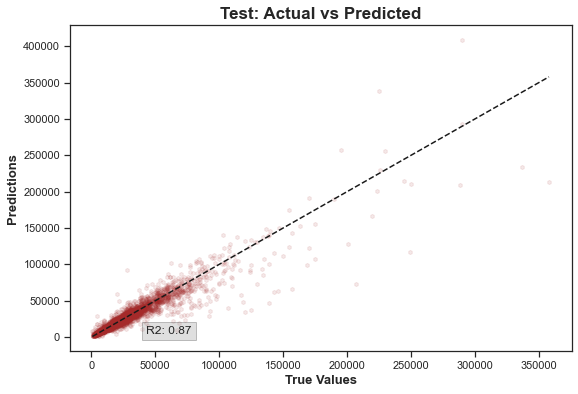

In [29]:
sns.set_style("ticks")

plt.figure(figsize = (9,6))
plt.scatter(x = y_test, y = y_pred, alpha = 0.1, c='brown', marker = 'h', s = 17)
plt.title('Test: Actual vs Predicted', fontsize = 17, weight = 'bold')
plt.ylabel('Predictions', fontsize = 13, weight = 'bold')
plt.xlabel('True Values', fontsize = 13, weight = 'bold')

plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], 'k', linestyle='--')
plt.text(43000,4000,'R2: {:.2f}'.format(r2), 
          bbox=dict(facecolor='grey', edgecolor = 'k', alpha=0.25))

plt.show()

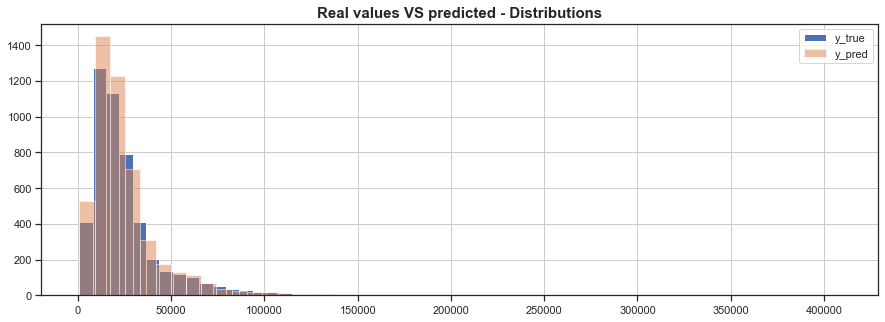

In [30]:
plt.figure(figsize = (15,5))

y_test.hist(bins = 50, label = 'y_true')
pd.Series(y_pred).hist(bins = 50, alpha = 0.5, label = 'y_pred')
plt.title('Real values VS predicted - Distributions', weight = 'bold', size = 15)
plt.legend()
plt.show()

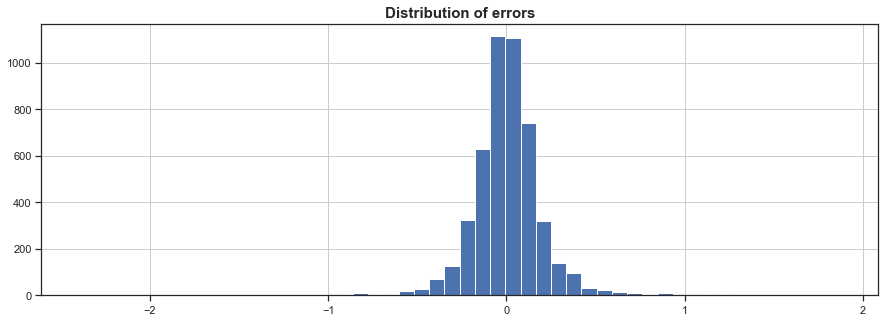

In [31]:
plt.figure(figsize = (15,5))
errors = np.log(y_test) - np.log(y_pred)
errors.hist(bins = 50)
plt.title('Distribution of errors', weight = 'bold', size = 15)
plt.show()

### Feature Importance

In [32]:
df_model = pd.DataFrame(
{
    'features':feat_names,
    'importance': model.feature_importances_
})
df_model = df_model.sort_values(by = ['importance'], ascending = False)

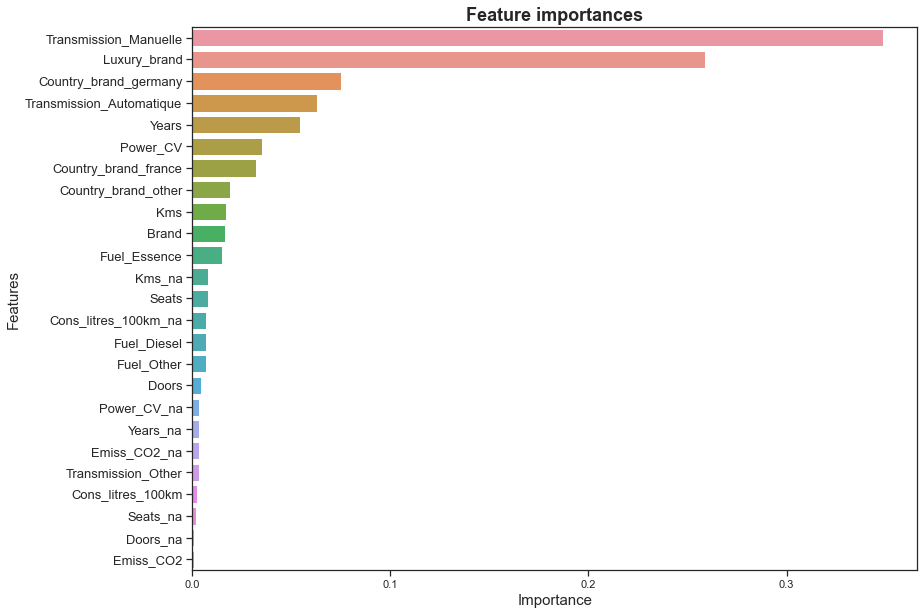

In [33]:
plt.figure(figsize = (13,10))

sns.barplot(y=df_model.features, x=df_model.importance)

plt.title('Feature importances', weight = 'bold', size = 18)
plt.yticks(fontsize = 13)
plt.xticks(np.arange(0,0.4,0.1))
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.show()

# Interpretability with Shapley values

In [34]:
df_X_test = pd.DataFrame(X_test, columns =feat_names)

In [35]:
explainer = shap.TreeExplainer(model, df_X_test)
shap_values = explainer(df_X_test)

100%|===================| 4853/4858 [05:45<00:00]        

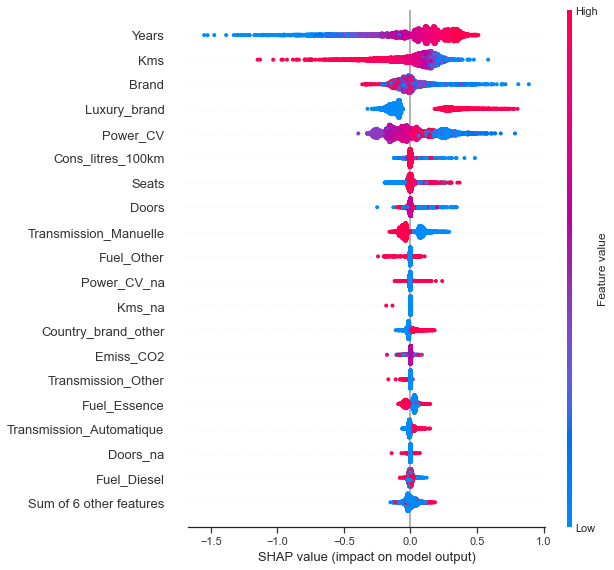

In [36]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display=20)

In [37]:
shap.plots.initjs()
shap.plots.force(shap_values[0])

In [38]:
# https://github.com/slundberg/shap/blob/master/notebooks/api_examples/plots/decision_plot.ipynb
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[0]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = df_X_test.iloc[select]
features_display = df_X_test.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[0]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[0]

Explainer expected value: 9.804244276749806


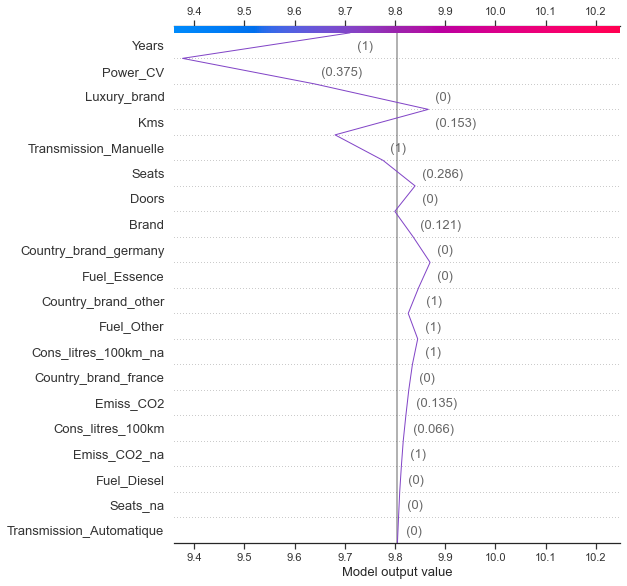

In [39]:
shap.decision_plot(expected_value, shap_values, features_display)